In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as skl
from sklearn import *
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

loc = 'workstation'
if loc == 'workstation':
    wd = 'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    # sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
elif loc == 'laptop':
    wd = '/Users/sammichekroud/Desktop/postdoc/tuningcurves'
sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
os.chdir(wd)
from funcs import getSubjectInfo
from TuningCurveFuncs import makeTuningCurve, getTuningCurve_FullSpace, createFeatureBins, visualise_FeatureBins

os.chdir(wd)
subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
#1,2,3,10,19 all have only 1 session. 23 something wrong in the second session, completely unusable eeg data due to serious noise
nsubs = subs.size
#set params for what file to load in per subject
binstep, binwidth  = 15, 22
# binstep, binwidth = 4, 11
#binstep, binwidth = 4, 16
binstep, binwidth = 4, 22

vis_500hz = True
if vis_500hz:
    freqtxt = '_500Hz'
    times = np.load(op.join(wd, 'data','tuningcurves', 'times_500hz.npy'))
else:
    freqtxt = ''
    times = np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy'))
times2 = np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy'))
ntimes2 = times2.size
ntimes = times.size
nitems = 2 #two items are presented in the array, we 'decode' both

nbins, binmids, binstarts, binends = createFeatureBins(binstep = binstep, binwidth = binwidth,
                                                       feature_start = -90+binstep, feature_end = 90)

<font color='red'>

first, read in each participants trialwise tuning curve. This comes as a matrix of shape `[items (2) x trials x bins x times]`

two items were presented in the stimulus array on each trial. Each item is 'decoded' separately and independently on each trial, so we get a 'tuning curve' per item in the array.

the matrix contains mahalanobis distances, where smaller values reflect representations that are more similar to the test trial (leave one out procedure), and larger values reflect representations more *dissimilar* to the test trial. Because of this, we sign-flip the distances such that larger numbers (less negative/more positive) reflect more similar representations.

single-trial tuning curves are averaged across trials separately for each decoded item, so we build up a tuning curve for the left/right item separately.

loading in 20 participants
done


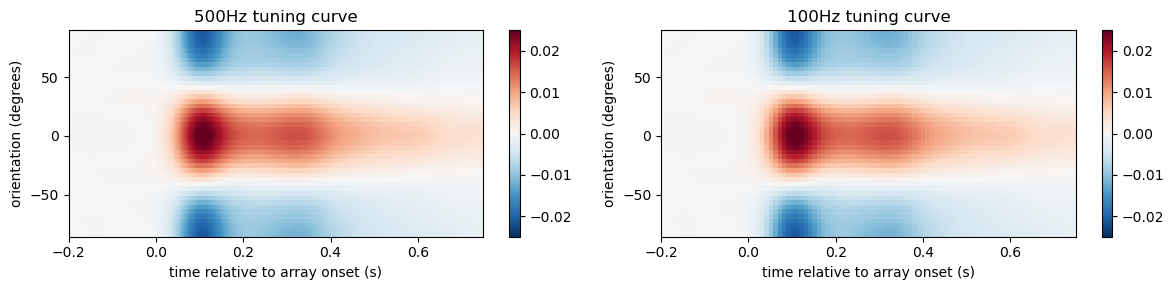

In [2]:
#visualise tuning curves where distances are lightly smoothed (30ms sd gaussian blur) across time, within each orientation bin
weightTrials = True

alldata = np.zeros(shape = [subs.size, nitems, binmids.size, ntimes]) * np.nan #2 because 2 items decoded
alldata2 = np.zeros(shape = [subs.size, nitems, binmids.size, ntimes2]) * np.nan
subcount = -1
print(f'loading in {subs.size} participants')
for i in subs:
    subcount +=1
    #print(f'working on ppt {subcount+1}/{subs.size}')
    
    #read in single subject data
    data = np.load(op.join(wd, 'data', 'tuningcurves', f's{i}_TuningCurve_mahaldists{freqtxt}_binstep{binstep}_binwidth{binwidth}_weightTrials{weightTrials}.npy'))
    data2 = np.load(op.join(wd, 'data', 'tuningcurves', f's{i}_TuningCurve_mahaldists_binstep{binstep}_binwidth{binwidth}_weightTrials{weightTrials}.npy'))
    bdata = pd.read_csv(op.join(wd, 'data', 'tuningcurves', f's{i}_TuningCurve_metadata.csv'))
    [nitems, ntrials, nbins, _] = data.shape
    
    data = data * -1 #invert this, so more positive (larger) values = closer (mahalnobis distances are small when test is close to train)
    data2 = data2 * -1
    smooth_dists = True
    if smooth_dists: #smooths distances across time, a little
        data  = sp.ndimage.gaussian_filter1d(data,  sigma = 15) #smooth distances with 10sample sd gaussian (20ms as 500Hz)
        data2 = sp.ndimage.gaussian_filter1d(data2, sigma = 3) #smooth distances with a 2sample sd gaussian (20ms as 100Hz)
    
    meandata = np.nanmean(data, axis=1)
    meandata2 = np.nanmean(data2, axis=1)
    alldata[subcount]  = meandata
    alldata2[subcount] = meandata2
print('done')

#for each participant and decoded item, demean across bins at each time point
gmean_tp = alldata.copy()
gmean_tp2 = alldata2.copy()
for isub in range(nsubs):
    for iitem in range(nitems):
        for tp in range(ntimes):
            gmean_tp[isub, iitem, :, tp] = np.subtract(gmean_tp[isub, iitem, :, tp], gmean_tp[isub, iitem, :, tp].mean())
        for tp in range(ntimes2):
            gmean_tp2[isub, iitem, :, tp] = np.subtract(gmean_tp2[isub, iitem, :, tp], gmean_tp2[isub, iitem, :, tp].mean())

gmean_ave = gmean_tp.mean(axis=1) #average across items
gmean_ave = gmean_ave.mean(0) #average across participants now

gmean_ave2 = gmean_tp2.mean(axis=1) #average across items
gmean_ave2 = gmean_ave2.mean(0) # average across participants now

vlims = 0.025
fig = plt.figure(figsize = [12, 3])
ax = fig.add_subplot(121)
plot = ax.imshow(gmean_ave, aspect='auto', origin = 'lower', cmap = 'RdBu_r', interpolation= 'none',
                 vmin = -vlims, vmax = vlims,
                 extent = [times.min(), times.max(), binmids.min(), binmids.max()])
fig.colorbar(plot)
ax.set_ylabel(f'orientation (degrees)');
ax.set_xlabel(f'time relative to array onset (s)');
# ax.set_xlim([-0.5,1.25]);
ax.set_xlim([-0.2, 0.75])
ax.set_title('500Hz tuning curve')
ax2 = fig.add_subplot(122)
plot2 = ax2.imshow(gmean_ave2, aspect = 'auto', origin = 'lower', cmap = 'RdBu_r', interpolation = 'none',
                  vmin = -vlims, vmax = vlims,
                  extent = [times2.min(), times2.max(), binmids.min(), binmids.max()])
fig.colorbar(plot2)
ax2.set_ylabel(f'orientation (degrees)');
ax2.set_xlabel(f'time relative to array onset (s)');
# ax2.set_xlim([-0.5,1.25]);
ax2.set_xlim([-0.2, 0.75])
ax2.set_title('100Hz tuning curve')

fig.tight_layout()

loading in 20 participants
done


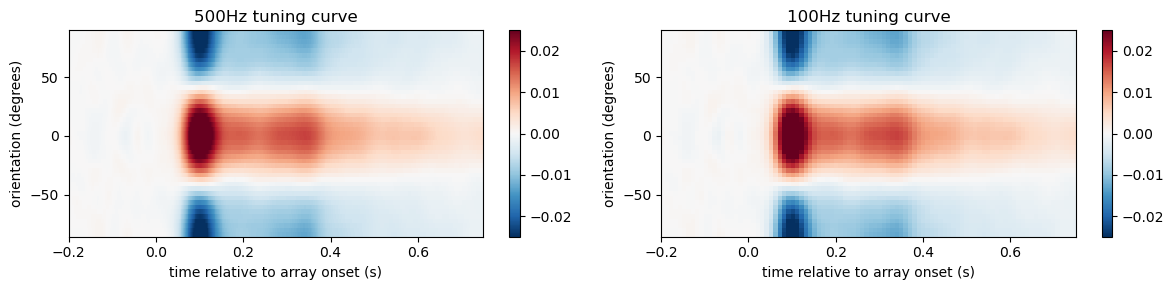

In [3]:
#load in and visualise tuning curves using raw (unsmoothed) distances from this point on
weightTrials = True

alldata = np.zeros(shape = [subs.size, nitems, binmids.size, ntimes]) * np.nan #2 because 2 items decoded
alldata2 = np.zeros(shape = [subs.size, nitems, binmids.size, ntimes2]) * np.nan
subcount = -1
print(f'loading in {subs.size} participants')
for i in subs:
    subcount +=1
    #print(f'working on ppt {subcount+1}/{subs.size}')
    
    #read in single subject data
    data = np.load(op.join(wd, 'data', 'tuningcurves', f's{i}_TuningCurve_mahaldists{freqtxt}_binstep{binstep}_binwidth{binwidth}_weightTrials{weightTrials}.npy'))
    data2 = np.load(op.join(wd, 'data', 'tuningcurves', f's{i}_TuningCurve_mahaldists_binstep{binstep}_binwidth{binwidth}_weightTrials{weightTrials}.npy'))
    bdata = pd.read_csv(op.join(wd, 'data', 'tuningcurves', f's{i}_TuningCurve_metadata.csv'))
    [nitems, ntrials, nbins, _] = data.shape
    
    data = data * -1 #invert this, so more positive (larger) values = closer (mahalnobis distances are small when test is close to train)
    data2 = data2 * -1
    smooth_dists = False
    if smooth_dists: #smooths distances across time, a little
        data  = sp.ndimage.gaussian_filter1d(data,  sigma = 10) #smooth distances with 10sample sd gaussian (20ms as 500Hz)
        data2 = sp.ndimage.gaussian_filter1d(data2, sigma = 2) #smooth distances with a 2sample sd gaussian (20ms as 100Hz)
    
    meandata = np.nanmean(data, axis=1)
    meandata2 = np.nanmean(data2, axis=1)
    alldata[subcount]  = meandata
    alldata2[subcount] = meandata2
print('done')

#for each participant and decoded item, demean across bins at each time point
gmean_tp = alldata.copy()
gmean_tp2 = alldata2.copy()
for isub in range(nsubs):
    for iitem in range(nitems):
        for tp in range(ntimes):
            gmean_tp[isub, iitem, :, tp] = np.subtract(gmean_tp[isub, iitem, :, tp], gmean_tp[isub, iitem, :, tp].mean())
        for tp in range(ntimes2):
            gmean_tp2[isub, iitem, :, tp] = np.subtract(gmean_tp2[isub, iitem, :, tp], gmean_tp2[isub, iitem, :, tp].mean())

gmean_ave = gmean_tp.mean(axis=1) #average across items
gmean_ave = gmean_ave.mean(0) #average across participants now

gmean_ave2 = gmean_tp2.mean(axis=1) #average across items
gmean_ave2 = gmean_ave2.mean(0) # average across participants now

vlims = 0.025
fig = plt.figure(figsize = [12, 3])
ax = fig.add_subplot(121)
plot = ax.imshow(gmean_ave, aspect='auto', origin = 'lower', cmap = 'RdBu_r', interpolation= 'none',
                 vmin = -vlims, vmax = vlims,
                 extent = [times.min(), times.max(), binmids.min(), binmids.max()])
fig.colorbar(plot)
ax.set_ylabel(f'orientation (degrees)');
ax.set_xlabel(f'time relative to array onset (s)');
# ax.set_xlim([-0.5,1.25]);
ax.set_xlim([-0.2, 0.75])
ax.set_title('500Hz tuning curve')
ax2 = fig.add_subplot(122)
plot2 = ax2.imshow(gmean_ave2, aspect = 'auto', origin = 'lower', cmap = 'RdBu_r', interpolation = 'none',
                  vmin = -vlims, vmax = vlims,
                  extent = [times2.min(), times2.max(), binmids.min(), binmids.max()])
fig.colorbar(plot2)
ax2.set_ylabel(f'orientation (degrees)');
ax2.set_xlabel(f'time relative to array onset (s)');
# ax2.set_xlim([-0.5,1.25]);
ax2.set_xlim([-0.2, 0.75])
ax2.set_title('100Hz tuning curve')

fig.tight_layout()

<font color='red'>

next, for each participant and item, per time point, we demean the distances across bins to normalise each time point. This still preserves shape such that more positive values reflect representations that are more similar to the left-out test trial.

after that, we average across the two items in the display to get the average tuning curve for both items combined (i.e. representation quality of the entire array), before averaging across participants to get the grand-mean tuning curve for the stimulus display


<font color='red'>

if we take windows of time in this tuning curve, we can plot the distances across orientation bins to observe how the shape of this curve changes over time

from this, fairly easy to see that pre-stimulus there is no real shape to the distribution of distances across orientations. Over time, there develops some orientation preference (leading to the cosine shape), which starts to decline in shape after 1s from stimulus onse.


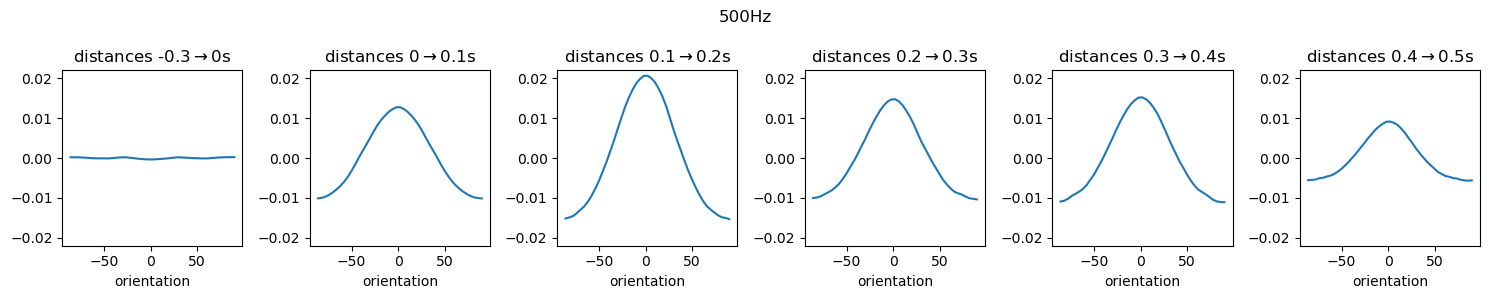

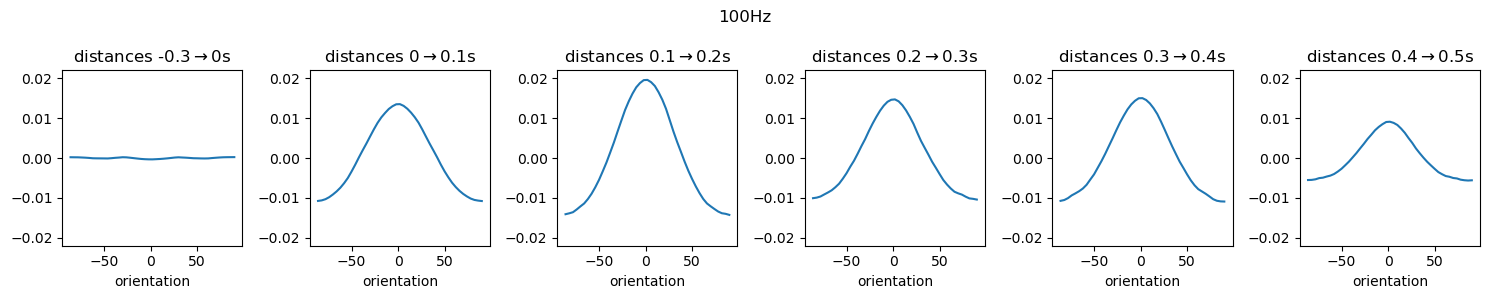

In [4]:
tstarts = [-0.3, 0,   0.1, 0.2, 0.3, 0.4]
tends   = [ 0,   0.1, 0.2, 0.3, 0.4, 0.5]
plotcount = np.arange(len(tstarts))+1
fig = plt.figure(figsize = [15, 3])
fig.suptitle('500Hz')
for x in zip(plotcount, tstarts, tends):
    ax = fig.add_subplot(1,6,x[0])
    tinds = np.logical_and(np.greater_equal(times, x[1]), np.less_equal(times, x[2]))
    tmpdat = np.nanmean(gmean_ave[:,tinds], axis=1) #average across time
    ax.plot(binmids, tmpdat)
    ax.set_xlabel('orientation')
    ax.set_title(f'distances {x[1]}$\\rightarrow${x[2]}s')
    ax.set_ylim([-0.022, 0.022])
fig.tight_layout()

fig = plt.figure(figsize = [15, 3])
fig.suptitle('100Hz')
for x in zip(plotcount, tstarts, tends):
    ax = fig.add_subplot(1,6,x[0])
    tinds = np.logical_and(np.greater_equal(times2, x[1]), np.less_equal(times2, x[2]))
    tmpdat = np.nanmean(gmean_ave2[:,tinds], axis=1) #average across time
    ax.plot(binmids, tmpdat)
    ax.set_xlabel('orientation')
    ax.set_title(f'distances {x[1]}$\\rightarrow${x[2]}s')
    ax.set_ylim([-0.022, 0.022])
fig.tight_layout()

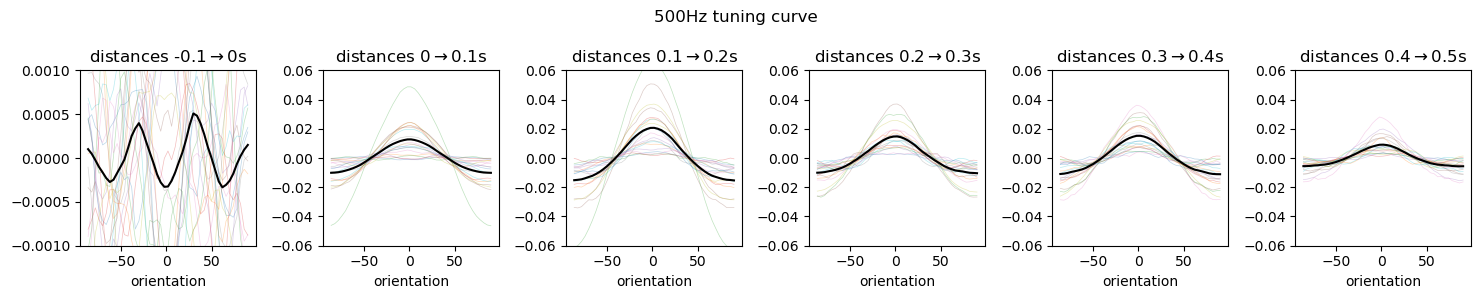

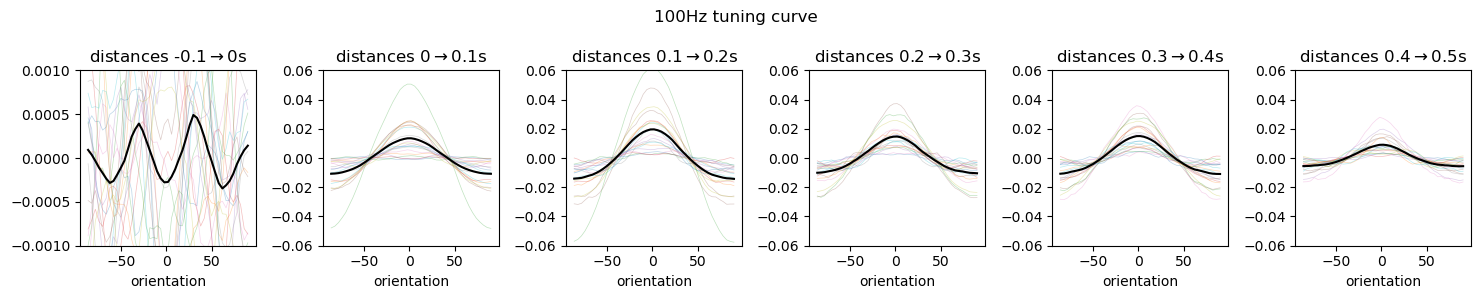

In [5]:
#plot single subjects with mean overlaid
tstarts = [-0.1, 0,   0.1, 0.2, 0.3, 0.4]
tends   = [ 0,   0.1, 0.2, 0.3, 0.4, 0.5]
plotcount = np.arange(len(tstarts))+1
fig = plt.figure(figsize = [15, 3])
for x in zip(plotcount, tstarts, tends):
    ax = fig.add_subplot(1,6,x[0])
    tinds = np.logical_and(np.greater_equal(times, x[1]), np.less_equal(times, x[2]))
    tmpdat = gmean_tp[:,:,:,tinds].copy() # ppts x items x bins x time
    tmpdat = tmpdat.mean(axis=3) #average across time, now ppts x items x bins
    tmpdat = tmpdat.mean(axis=1) #average across items, now ppts x bins
    ax.plot(binmids, tmpdat.T, alpha = 0.3, lw = 0.5)
    ax.plot(binmids, tmpdat.mean(0), color = 'k', lw = 1.5)
    ax.set_xlabel('orientation')
    ax.set_title(f'distances {x[1]}$\\rightarrow${x[2]}s')
    if x[0] == 1:
        ax.set_ylim([-0.001, 0.001])
    else:
        ax.set_ylim([-0.06, 0.06])
fig.suptitle('500Hz tuning curve')
fig.tight_layout()

fig = plt.figure(figsize = [15, 3])
for x in zip(plotcount, tstarts, tends):
    ax = fig.add_subplot(1,6,x[0])
    tinds = np.logical_and(np.greater_equal(times2, x[1]), np.less_equal(times2, x[2]))
    tmpdat = gmean_tp2[:,:,:,tinds].copy() # ppts x items x bins x time
    tmpdat = tmpdat.mean(axis=3) #average across time, now ppts x items x bins
    tmpdat = tmpdat.mean(axis=1) #average across items, now ppts x bins
    ax.plot(binmids, tmpdat.T, alpha = 0.3, lw = 0.5)
    ax.plot(binmids, tmpdat.mean(0), color = 'k', lw = 1.5)
    ax.set_xlabel('orientation')
    ax.set_title(f'distances {x[1]}$\\rightarrow${x[2]}s')
    if x[0] == 1:
        ax.set_ylim([-0.001, 0.001])
    else:
        ax.set_ylim([-0.06, 0.06])
fig.suptitle('100Hz tuning curve')
fig.tight_layout()

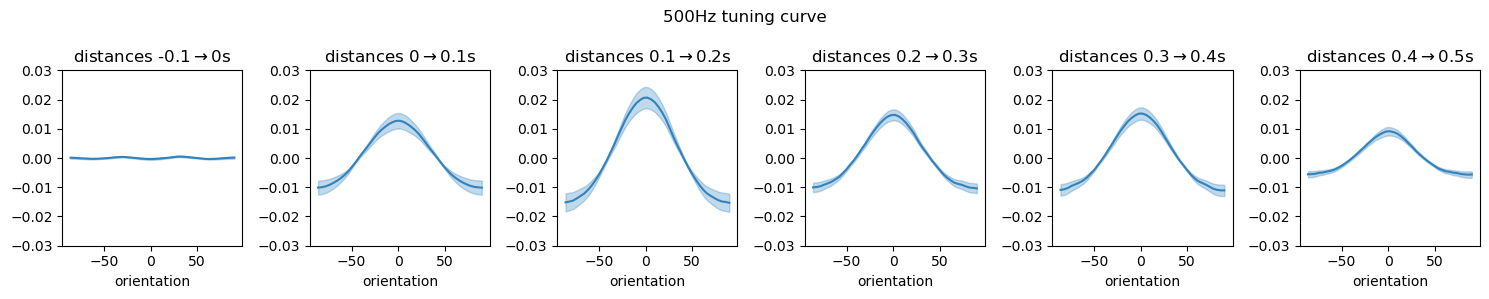

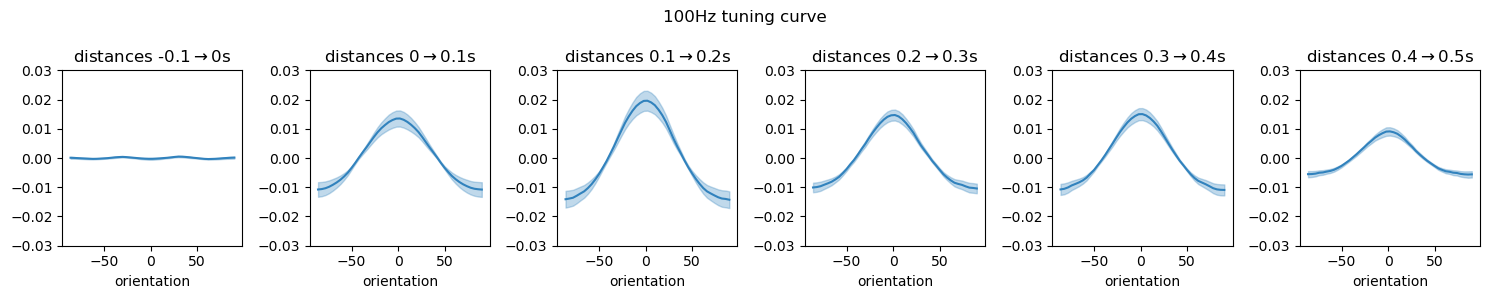

In [6]:
#plot across subjects mean + std error
tstarts = [-0.1, 0,   0.1, 0.2, 0.3, 0.4]
tends   = [ 0,   0.1, 0.2, 0.3, 0.4, 0.5]
plotcount = np.arange(len(tstarts))+1
fig = plt.figure(figsize = [15, 3])
for x in zip(plotcount, tstarts, tends):
    ax = fig.add_subplot(1,6,x[0])
    tinds = np.logical_and(np.greater_equal(times, x[1]), np.less_equal(times, x[2]))
    tmpdat = gmean_tp[:,:,:,tinds].copy() # ppts x items x bins x time
    tmpdat = tmpdat.mean(axis=3) #average across time, now ppts x items x bins
    tmpdat = tmpdat.mean(axis=1) #average across items, now ppts x bins
    imean = tmpdat.mean(0)
    isem  = sp.stats.sem(tmpdat, axis=0, ddof=0, nan_policy='omit')
    ax.plot(binmids, imean, lw = 1.5, color = '#3182bd')
    ax.fill_between(binmids, np.add(imean, isem), np.subtract(imean, isem), edgecolor=None, alpha = 0.3, color='#3182bd')
    ax.set_xlabel('orientation')
    ax.set_title(f'distances {x[1]}$\\rightarrow${x[2]}s')
    ax.set_ylim([-0.03, 0.03])
fig.suptitle('500Hz tuning curve')
fig.tight_layout()

fig = plt.figure(figsize = [15, 3])
for x in zip(plotcount, tstarts, tends):
    ax = fig.add_subplot(1,6,x[0])
    tinds = np.logical_and(np.greater_equal(times2, x[1]), np.less_equal(times2, x[2]))
    tmpdat = gmean_tp2[:,:,:,tinds].copy() # ppts x items x bins x time
    tmpdat = tmpdat.mean(axis=3) #average across time, now ppts x items x bins
    tmpdat = tmpdat.mean(axis=1) #average across items, now ppts x bins
    imean = tmpdat.mean(0)
    isem  = sp.stats.sem(tmpdat, axis=0, ddof=0, nan_policy='omit')
    ax.plot(binmids, imean, lw = 1.5, color = '#3182bd')
    ax.fill_between(binmids, np.add(imean, isem), np.subtract(imean, isem), edgecolor=None, alpha = 0.3, color='#3182bd')
    ax.set_xlabel('orientation')
    ax.set_title(f'distances {x[1]}$\\rightarrow${x[2]}s')
    ax.set_ylim([-0.03, 0.03])
fig.suptitle('100Hz tuning curve')
fig.tight_layout()